---

The aims of this demonstration are to:

1. Understand the MST synthesis method from a high level
2. Visualise the impact of adding noise during synthesis
3. Observe some of the limitations of the method

To do this, we will be synthesising the 1% Teaching File and following the path of a particular set of columns.

Moreover, to emphasise the importance of adding noise in achieving disclosure control,
we will focus on a pair of columns with a very small count in their two-way marginal table.

In [1]:
import base64
import binascii
import io
import itertools
import textwrap

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sbn
from IPython.display import display, HTML, Image
from matplotlib.gridspec import GridSpec
from mbi import Dataset, Domain, FactoredInference
from sklearn.preprocessing import OrdinalEncoder

import mst
from cdp2adp import cdp_rho

sbn.set_style("ticks")

%load_ext pretty_jupyter

In [2]:
def encode_data(data):
    """Use an ordinal encoder to convert categorical data."""

    encoder = OrdinalEncoder().fit(data)
    data = pd.DataFrame(
        encoder.transform(data).astype(int), columns=data.columns
    )

    return data, encoder


def load_data(path, skip=1):
    """Read in and prepare the data for synthesis."""

    data = pd.read_csv(path, skiprows=skip).drop("Person ID", axis=1)
    data, encoder = encode_data(data)

    return data, encoder


def decode_data(data, encoder):
    """Decode the data so it is interpretable."""

    return pd.DataFrame(encoder.inverse_transform(data), columns=data.columns)


def get_sparse_column_pair(data):
    """Get the column pair with the lowest two-way marginal count."""

    pair = None
    min_cell_count = np.inf
    for a, b in itertools.combinations(data.columns, r=2):
        count = data.groupby([a, b]).size().min()
        if count < min_cell_count:
            min_cell_count = count
            pair = [a, b]

    return pair


def calculate_marginal_table(data, by, encoder=None):
    """Get a marginal table for a column or set thereof."""

    if encoder is not None:
        data = data.pipe(decode_data, encoder)

    table = data.groupby(by).size().rename("count").reset_index()

    if not isinstance(by, str) and len(by) > 1:
        table = table.pivot(*by, "count")

    return table

---

# The MST method

Maximum Spanning Tree (MST) is a data synthesis method for synthesising categorical data while preserving privacy.
The authors of MST [won the 2018 NIST competition](https://doi.org/10.29012/jpc.778) for differential privacy (DP) and data synthesis.
The team won using a variant of MST tailored to the contest dataset - extracts from the 1940 US Census.

There are three main steps to MST:

1. **Select** a collection of one- and two-way marginals from the data
2. **Measure** the marginals privately by adding a controlled amount of noise to each cell count
3. **Generate** synthetic data that attempts to match the noisy marginals

MST is a flexible, scalable method that can preserve interactions in the data beyond those it measures.
This accuracy for latent relationships comes in the **generate** step which employs the [`Private-PGM`](http://proceedings.mlr.press/v97/mckenna19a.html) method.
`Private-PGM` represents the noisy marginals as a graph with nodes and edges.

Since MST is a _differentially private_ synthesis method, we must also specify a privacy budget.
The variant of DP used in MST requires two parameters, $\epsilon > 0$ and $0 < \delta \ll \epsilon$.
These parameters control the amount of noise added to marginals, and the pseudo-randomness of the selection process.

Choosing $\delta$ is relatively straightforward so long as it is smaller than $\frac{1}{N}$ where $N$ is the length of the dataset to be synthesised.
Choosing the primary privacy budget $\epsilon$ is much more nuanced and broadly determines how accurate the synthetic data may be.
While larger values are commonly used in practice, [one of the authors of DP argues](https://doi.org/10.1145/1866739.1866758) that $0.01 \approx \ln(1.01) \le \epsilon \le \ln(3) \approx 1.1$ is a suitable range.

For this demonstration, we take $\epsilon = 1$ and
$\delta = 10 ^ {- ceil\left(\log_{10} N\right)} = 10 ^ {-6}$, where $ceil$ is the ceiling function.

In [3]:
data, encoder = load_data("main.csv")
a, b = pair = get_sparse_column_pair(data)

np.random.seed(0)
epsilon, delta = 1, 10 ** -np.ceil(np.log10(len(data)))
dataset = Dataset(data, Domain.fromdict(data.nunique().to_dict()))

In [4]:
rho = cdp_rho(epsilon, delta)
sigma = np.sqrt(3 / (2 * rho))
cliques = [(col,) for col in dataset.domain]
log1 = mst.measure(dataset, cliques, sigma)
dataset, log1, undo_compress_fn = mst.compress_domain(dataset, log1)

cliques = mst.select(dataset, rho / 3.0, log1, cliques=[tuple(pair)])
log2 = mst.measure(dataset, cliques, sigma)

engine = FactoredInference(dataset.domain, iters=5000)
est = engine.estimate(log1 + log2)
synth = undo_compress_fn(est.synthetic_data())

In [5]:
rows, cols = data.shape
rows = f"{rows:,}"

In [6]:
def overflow_html(df):
    """Render a dataframe with a horizontal scroll bar."""

    style = "display:flex; justify-content:centre; overflow:auto; width:100%"

    html = f"<div style='{style}'>"
    html += df.to_html()
    html += "</div>"

    display(HTML(html))

In [7]:
%%jmd

---

# The 1% Census

One of the outputs from the 2011 Census in England and Wales is the
[Microdata Teaching File](https://www.ons.gov.uk/census/2011census/2011censusdata/censusmicrodata/microdatateachingfile).
This file contains a 1% sample of the person records from the Census;
all records are anonymised and chosen at random.
Excluding the person ID, the data comprises {{ cols }} columns and {{ rows }} rows.

The primary purpose of the teaching file is an educational tool,
but it also offers up a glance at what genuine Census microdata look like.
Using this dataset to demonstrate the MST method seems sensible then,
given its previous applications to census data.

## Snippets

Below is a snapshot of the original data,
and a similar snapshot of the synthetic data beneath that.
While it may seem like we are skipping ahead,
these snippets make clear what our end goal looks like.
That is, a synthetic dataset that looks quite like the real thing.


---

# The 1% Census

One of the outputs from the 2011 Census in England and Wales is the
[Microdata Teaching File](https://www.ons.gov.uk/census/2011census/2011censusdata/censusmicrodata/microdatateachingfile).
This file contains a 1% sample of the person records from the Census;
all records are anonymised and chosen at random.
Excluding the person ID, the data comprises 17 columns and 569,741 rows.

The primary purpose of the teaching file is an educational tool,
but it also offers up a glance at what genuine Census microdata look like.
Using this dataset to demonstrate the MST method seems sensible then,
given its previous applications to census data.

## Snippets

Below is a snapshot of the original data,
and a similar snapshot of the synthetic data beneath that.
While it may seem like we are skipping ahead,
these snippets make clear what our end goal looks like.
That is, a synthetic dataset that looks quite like the real thing.

In [8]:
data.pipe(decode_data, encoder).head().pipe(overflow_html)

,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
0,E12000001,H,2,1,2,6,2,2,1,2,1,2,5,8,2,-9,4
1,E12000001,H,5,1,1,4,1,2,1,1,1,2,1,8,6,4,3
2,E12000001,H,3,1,2,4,1,2,1,1,1,1,1,6,11,3,4
3,E12000001,H,3,1,2,2,1,2,1,2,1,2,1,7,7,3,2
4,E12000001,H,3,1,1,5,4,2,1,1,1,2,1,1,4,3,2


In [9]:
synth.df.pipe(decode_data, encoder).head().pipe(overflow_html)

,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
0,E12000003,H,5,1,1,1,1,1,1,1,1,2,-9,-9,-9,-9,-9
1,W92000004,H,5,1,1,4,1,2,1,1,1,1,1,5,3,3,3
2,E12000007,H,2,1,1,8,2,2,1,1,1,1,5,5,3,-9,2
3,W92000004,H,2,1,1,6,2,2,1,3,1,2,5,9,10,-9,2
4,W92000004,H,2,1,2,2,1,1,1,1,1,1,6,6,11,-9,3


---

# Our pair of columns

Our demonstration follows the trajectory of two columns in the teaching file, `Population Base` and `Marital Status`.

`Population Base` describes the individual's residency:
  1. Usual resident
  2. Student living away from home during term-time
  3. Short-term resident

`Marital Status` describes the individual's marital status:
  1. Single (never married or never registered a same-sex civil partnership) 
  2. Married or in a registered same-sex civil partnership 
  3. Separated but still legally married or separated but still legally in a same-sex civil partnership 
  4. Divorced or formerly in a same-sex civil partnership which is now legally dissolved 
  5. Widowed or surviving partner from a same-sex civil partnership

These columns are heavily unbalanced in the data with 98% of individuals being usual residents,
and 85% of individuals either being single or in a legally binding relationship, i.e., married or in a registered same-sex civil partnership:

In [10]:
tables = []
for col in pair:
    table = calculate_marginal_table(data, col, encoder)
    table["proportion"] = (table["count"] / table["count"].sum()).round(4)
    tables.append(table.set_index(col))

In [11]:
%%jmd

## One-way counts
[//]: # (-.- .tabset)

### {{ a }}

{{ tables[0].style.format("{:,}").to_html() }}

### {{ b }}

{{ tables[1].style.format("{:,}").to_html() }}



## One-way counts
<span class='pj-token' style='display: none;'>.tabset</span>

### Population Base

<style type="text/css">
</style>
<table id="T_27bd7">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_27bd7_level0_col0" class="col_heading level0 col0" >count</th>
      <th id="T_27bd7_level0_col1" class="col_heading level0 col1" >proportion</th>
    </tr>
    <tr>
      <th class="index_name level0" >Population Base</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_27bd7_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_27bd7_row0_col0" class="data row0 col0" >561,040</td>
      <td id="T_27bd7_row0_col1" class="data row0 col1" >0.9847</td>
    </tr>
    <tr>
      <th id="T_27bd7_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_27bd7_row1_col0" class="data row1 col0" >6,730</td>
      <td id="T_27bd7_row1_col1" class="data row1 col1" >0.0118</td>
    </tr>
    <tr>
      <th id="T_27bd7_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_27bd7_row2_col0" class="data row2 col0" >1,971</td>
      <td id="T_27bd7_row2_col1" class="data row2 col1" >0.0035</td>
    </tr>
  </tbody>
</table>


### Marital Status

<style type="text/css">
</style>
<table id="T_de3e7">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_de3e7_level0_col0" class="col_heading level0 col0" >count</th>
      <th id="T_de3e7_level0_col1" class="col_heading level0 col1" >proportion</th>
    </tr>
    <tr>
      <th class="index_name level0" >Marital Status</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_de3e7_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_de3e7_row0_col0" class="data row0 col0" >270,999</td>
      <td id="T_de3e7_row0_col1" class="data row0 col1" >0.4757</td>
    </tr>
    <tr>
      <th id="T_de3e7_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_de3e7_row1_col0" class="data row1 col0" >214,180</td>
      <td id="T_de3e7_row1_col1" class="data row1 col1" >0.3759</td>
    </tr>
    <tr>
      <th id="T_de3e7_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_de3e7_row2_col0" class="data row2 col0" >11,951</td>
      <td id="T_de3e7_row2_col1" class="data row2 col1" >0.021</td>
    </tr>
    <tr>
      <th id="T_de3e7_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_de3e7_row3_col0" class="data row3 col0" >40,713</td>
      <td id="T_de3e7_row3_col1" class="data row3 col1" >0.0715</td>
    </tr>
    <tr>
      <th id="T_de3e7_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_de3e7_row4_col0" class="data row4 col0" >31,898</td>
      <td id="T_de3e7_row4_col1" class="data row4 col1" >0.056</td>
    </tr>
  </tbody>
</table>

## Two-way counts

The primary reason we are interested in these columns, however, is because they have a two-way marginal table with some very low counts:

In [12]:
calculate_marginal_table(data, pair, encoder).style.format("{:,d}")

Marital Status,1,2,3,4,5
Population Base,,,,,
1,"262,807","213,777","11,930","40,664","31,862"
2,"6,684",28,8,9,1
3,"1,508",375,13,40,35


Typically, data owners might be hesistant to disclose information like this,
since there is only one individual in the data who is both a student and widowed.
In the case of the 1% Teaching File, the data is so granular that reidentification of this individual is incredibly small.

However, in a more fine-grained, confidential dataset, this would be a problem.

---

# Adding noise

To ensure the privacy of the individuals in the dataset, MST adds noise to all of these counts.
In MST, the noise is Gaussian and centred on zero.
The standard deviation of the noise distribution is determined by the privacy budget and how many measurements are taken.

MST measures all 17 one-way marginals and a selection of two-way marginals.
One third of the privacy budget is spent randomly selecting these two-way marginals.

For $\epsilon = 1$ and $\delta = 10^{-6}$, MST adds $\mathcal{N}(0, 32.36)$ noise to the one-way marginal tables.

In [13]:
weights = np.ones(len(data.columns))
weights /= np.linalg.norm(weights)

assert round(sigma / weights[0], 2) == 32.36

MST selects enough two-way marginals to connect all the columns using a graphical representation.
In this representation, columns are nodes and an edge on the graph indicates the selection of the two-way marginal between the nodes.

As such, MST must measure a minimum of 16 two-way marginals to form a minimum spanning tree of the column nodes.
In practice, the final graph is not always a tree and may contain triangles. Here, this is not the case.

For our example, MST adds $\mathcal{N}(0, 31.39)$ noise to each two-way marginal's cell counts.

In [14]:
weights = np.ones(len(data.columns) - 1)
weights /= np.linalg.norm(weights)

assert round(sigma / weights[0], 2) == 31.39

---

# Generating the synthetic data

With the marginals selected and measured (with added noise), they can be passed to the `Private-PGM` method to create tabular data.
In short, `Private-PGM` attempts to find a data distribution that matches the noisy marginals by solving an optimisation problem.

## Mapping out the synthesis

The synthetic dataset is generated by traversing a directed acyclic graph of the selected marginals,
and sampling as need from the estimated distribution.

The figure below shows the graph for this synthesis, showing how the generation was performed.

Each column is represented as a node, and an edge between two nodes indicates that their two-way marginal
was selected for synthesis. The direction of an edge `(a, b)` indicates that the column `a` is used to
synthesise column `b`.

This graph shows that `Industry` was synthesised first with no dependent columns.
Then the synthetic `Industry` column was used to synthesise `Occupation`, and so on.

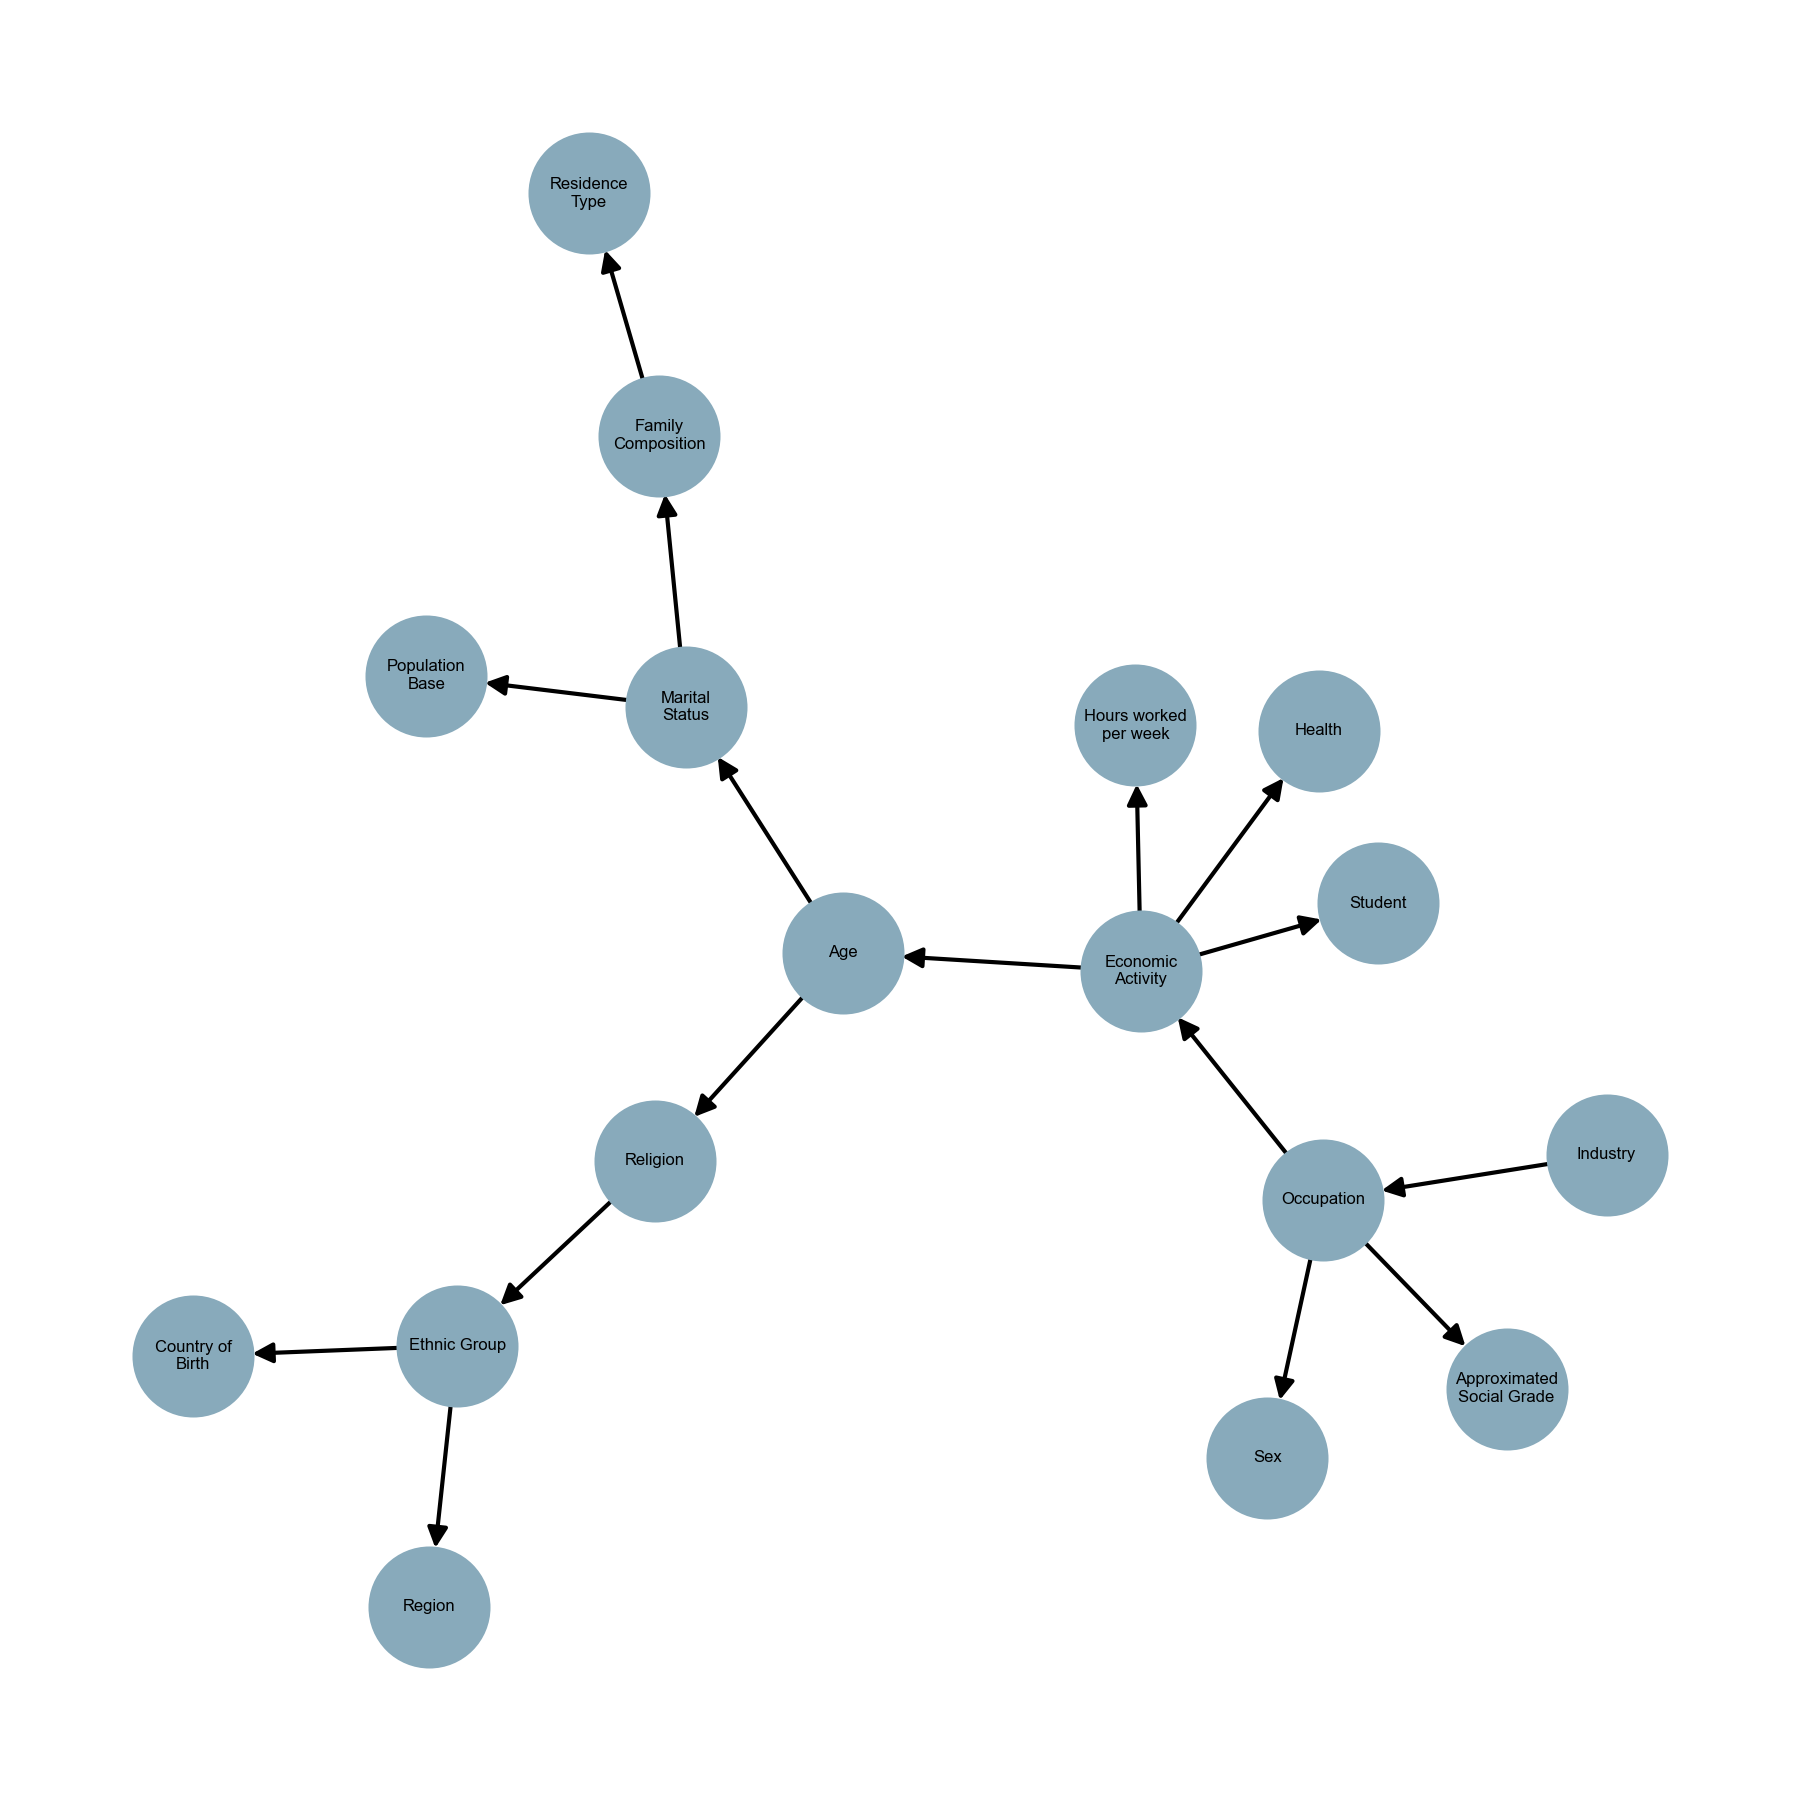

In [15]:
ordered_cliques = [
    sorted(clique, key=est.elimination_order[::-1].index) for clique in cliques
]

wrapped_cliques = [
    tuple(textwrap.fill(col, 12) for col in clique)
    for clique in ordered_cliques
]

graph = nx.DiGraph()
graph.add_edges_from(wrapped_cliques)
pos = nx.nx_agraph.graphviz_layout(graph, root=est.elimination_order[-1])

with io.BytesIO() as sio:
    fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
    nx.draw(
        graph,
        pos,
        ax=ax,
        with_labels=True,
        node_size=800,
        node_color="#8ab",
        font_size=4,
    )

    plt.tight_layout()
    fig.canvas.print_png(sio)
    img = binascii.b2a_base64(sio.getvalue())

plt.close()
display(Image(base64.b64decode(img)))

In [16]:
def get_noisy_one_way(log1, col):
    """Get the noisy marginal table for a column."""

    noisy = (
        pd.DataFrame(
            {
                "noisy": next(
                    counts for _, counts, _, clique in log1 if clique == (col,)
                )
            }
        )
        .rename_axis(index=col)
        .reset_index()
    )

    return noisy


def compare_one_ways(data, log1, synth, col):
    """Get a table comparing all the various one-way tables."""

    original = data.pipe(calculate_marginal_table, col).rename(
        {"count": "observed"}, axis=1
    )
    noisy = get_noisy_one_way(log1, col)
    synthetic = synth.df.pipe(calculate_marginal_table, col).rename(
        {"count": "synthetic"}, axis=1
    )

    comparison = (
        original.merge(noisy, on=col).merge(synthetic, on=col).set_index(col)
    )
    comparison.index += 1

    return comparison

In [17]:
%%jmd

---

# Comparing the marginal counts

## One-way marginals
[//]: # (-.- .tabset)

To demonstrate the impact of adding noise to the marginal tables, consider the tables below,
which show the observed, noisy and synthesised counts for each our columns of interest.

### {{ a }}

{{ compare_one_ways(data, log1, synth, a).round(2).style.format("{:,}").to_html() }}


### {{ b }}

{{ compare_one_ways(data, log1, synth, b).round(2).style.format("{:,}").to_html() }}


---

# Comparing the marginal counts

## One-way marginals
<span class='pj-token' style='display: none;'>.tabset</span>

To demonstrate the impact of adding noise to the marginal tables, consider the tables below,
which show the observed, noisy and synthesised counts for each our columns of interest.

### Population Base

<style type="text/css">
</style>
<table id="T_2501e">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_2501e_level0_col0" class="col_heading level0 col0" >observed</th>
      <th id="T_2501e_level0_col1" class="col_heading level0 col1" >noisy</th>
      <th id="T_2501e_level0_col2" class="col_heading level0 col2" >synthetic</th>
    </tr>
    <tr>
      <th class="index_name level0" >Population Base</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_2501e_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_2501e_row0_col0" class="data row0 col0" >561,040</td>
      <td id="T_2501e_row0_col1" class="data row0 col1" >561,012.36</td>
      <td id="T_2501e_row0_col2" class="data row0 col2" >560,993</td>
    </tr>
    <tr>
      <th id="T_2501e_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_2501e_row1_col0" class="data row1 col0" >6,730</td>
      <td id="T_2501e_row1_col1" class="data row1 col1" >6,647.39</td>
      <td id="T_2501e_row1_col2" class="data row1 col2" >6,730</td>
    </tr>
    <tr>
      <th id="T_2501e_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_2501e_row2_col0" class="data row2 col0" >1,971</td>
      <td id="T_2501e_row2_col1" class="data row2 col1" >1,992.15</td>
      <td id="T_2501e_row2_col2" class="data row2 col2" >2,002</td>
    </tr>
  </tbody>
</table>



### Marital Status

<style type="text/css">
</style>
<table id="T_514bc">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_514bc_level0_col0" class="col_heading level0 col0" >observed</th>
      <th id="T_514bc_level0_col1" class="col_heading level0 col1" >noisy</th>
      <th id="T_514bc_level0_col2" class="col_heading level0 col2" >synthetic</th>
    </tr>
    <tr>
      <th class="index_name level0" >Marital Status</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_514bc_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_514bc_row0_col0" class="data row0 col0" >270,999</td>
      <td id="T_514bc_row0_col1" class="data row0 col1" >270,970.27</td>
      <td id="T_514bc_row0_col2" class="data row0 col2" >270,944</td>
    </tr>
    <tr>
      <th id="T_514bc_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_514bc_row1_col0" class="data row1 col0" >214,180</td>
      <td id="T_514bc_row1_col1" class="data row1 col1" >214,115.91</td>
      <td id="T_514bc_row1_col2" class="data row1 col2" >214,146</td>
    </tr>
    <tr>
      <th id="T_514bc_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_514bc_row2_col0" class="data row2 col0" >11,951</td>
      <td id="T_514bc_row2_col1" class="data row2 col1" >11,939.74</td>
      <td id="T_514bc_row2_col2" class="data row2 col2" >11,948</td>
    </tr>
    <tr>
      <th id="T_514bc_level0_row3" class="row_heading level0 row3" >4</th>
      <td id="T_514bc_row3_col0" class="data row3 col0" >40,713</td>
      <td id="T_514bc_row3_col1" class="data row3 col1" >40,718.06</td>
      <td id="T_514bc_row3_col2" class="data row3 col2" >40,739</td>
    </tr>
    <tr>
      <th id="T_514bc_level0_row4" class="row_heading level0 row4" >5</th>
      <td id="T_514bc_row4_col0" class="data row4 col0" >31,898</td>
      <td id="T_514bc_row4_col1" class="data row4 col1" >31,937.81</td>
      <td id="T_514bc_row4_col2" class="data row4 col2" >31,948</td>
    </tr>
  </tbody>
</table>

We can see that for this privacy budget and this particular run of MST, these counts are all rather close. Success!

However, accurately recreating individuals columns is a relatively low bar for data synthesis.

In [18]:
def get_noisy_two_way(log2, pair, domain):
    """Get the noisy marginal table for a pair of columns."""

    a, b = pair
    shape = domain.project(pair).shape

    noisy = pd.DataFrame(
        next(
            counts for _, counts, _, clique in log2 if clique == tuple(pair)
        ).reshape(shape)
    ).rename_axis(index=a, columns=b)

    noisy.index += 1
    noisy.columns += 1

    return noisy

In [19]:
original_pair = calculate_marginal_table(data, pair, encoder)
noisy_pair = get_noisy_two_way(log2, pair, dataset.domain)
synthetic_pair = calculate_marginal_table(synth.df, pair, encoder)

tables = (original_pair, noisy_pair, synthetic_pair)

vmin = np.log(max(1, min(x.min().min() for x in tables)))
vmax = np.log(max(x.max().max() for x in tables))

In [20]:
%%jmd

## Two-way marginals

The figures below show the marginal table for our pair of columns for the original data,
its noisy counterpart, and the synthetic dataset.
The colour map indicates the count in each cell, and is consistent across the figures.

From these figures we can see that the larger counts are less affected by the noise
and appear to be very accurately preserved,
which makes sense - they carry a lower disclosure risk.
The smaller counts, especially the unique individual in the original data,
however, are perturbed to a much greater effect.
This could be a problem if the users of this synthetic data are interested in studying edge-populations such as this.

Looking at the noisy table, we can see that the Gaussian noise has actually pushed some
counts below zero.
The generation step of MST considers the one-way marginal table and the amount of noise added to form the noisy counts, allowing the synthetic data to still resemble the original. In fact, with the noise added, the mean absolute difference between the original and synthetic counts for this marginal table is
{{ (synthetic_pair - original_pair).abs().mean().mean() }},
which falls in line with the Gaussian noise added.


## Two-way marginals

The figures below show the marginal table for our pair of columns for the original data,
its noisy counterpart, and the synthetic dataset.
The colour map indicates the count in each cell, and is consistent across the figures.

From these figures we can see that the larger counts are less affected by the noise
and appear to be very accurately preserved,
which makes sense - they carry a lower disclosure risk.
The smaller counts, especially the unique individual in the original data,
however, are perturbed to a much greater effect.
This could be a problem if the users of this synthetic data are interested in studying edge-populations such as this.

Looking at the noisy table, we can see that the Gaussian noise has actually pushed some
counts below zero.
The generation step of MST considers the one-way marginal table and the amount of noise added to form the noisy counts, allowing the synthetic data to still resemble the original. In fact, with the noise added, the mean absolute difference between the original and synthetic counts for this marginal table is
28.0,
which falls in line with the Gaussian noise added.

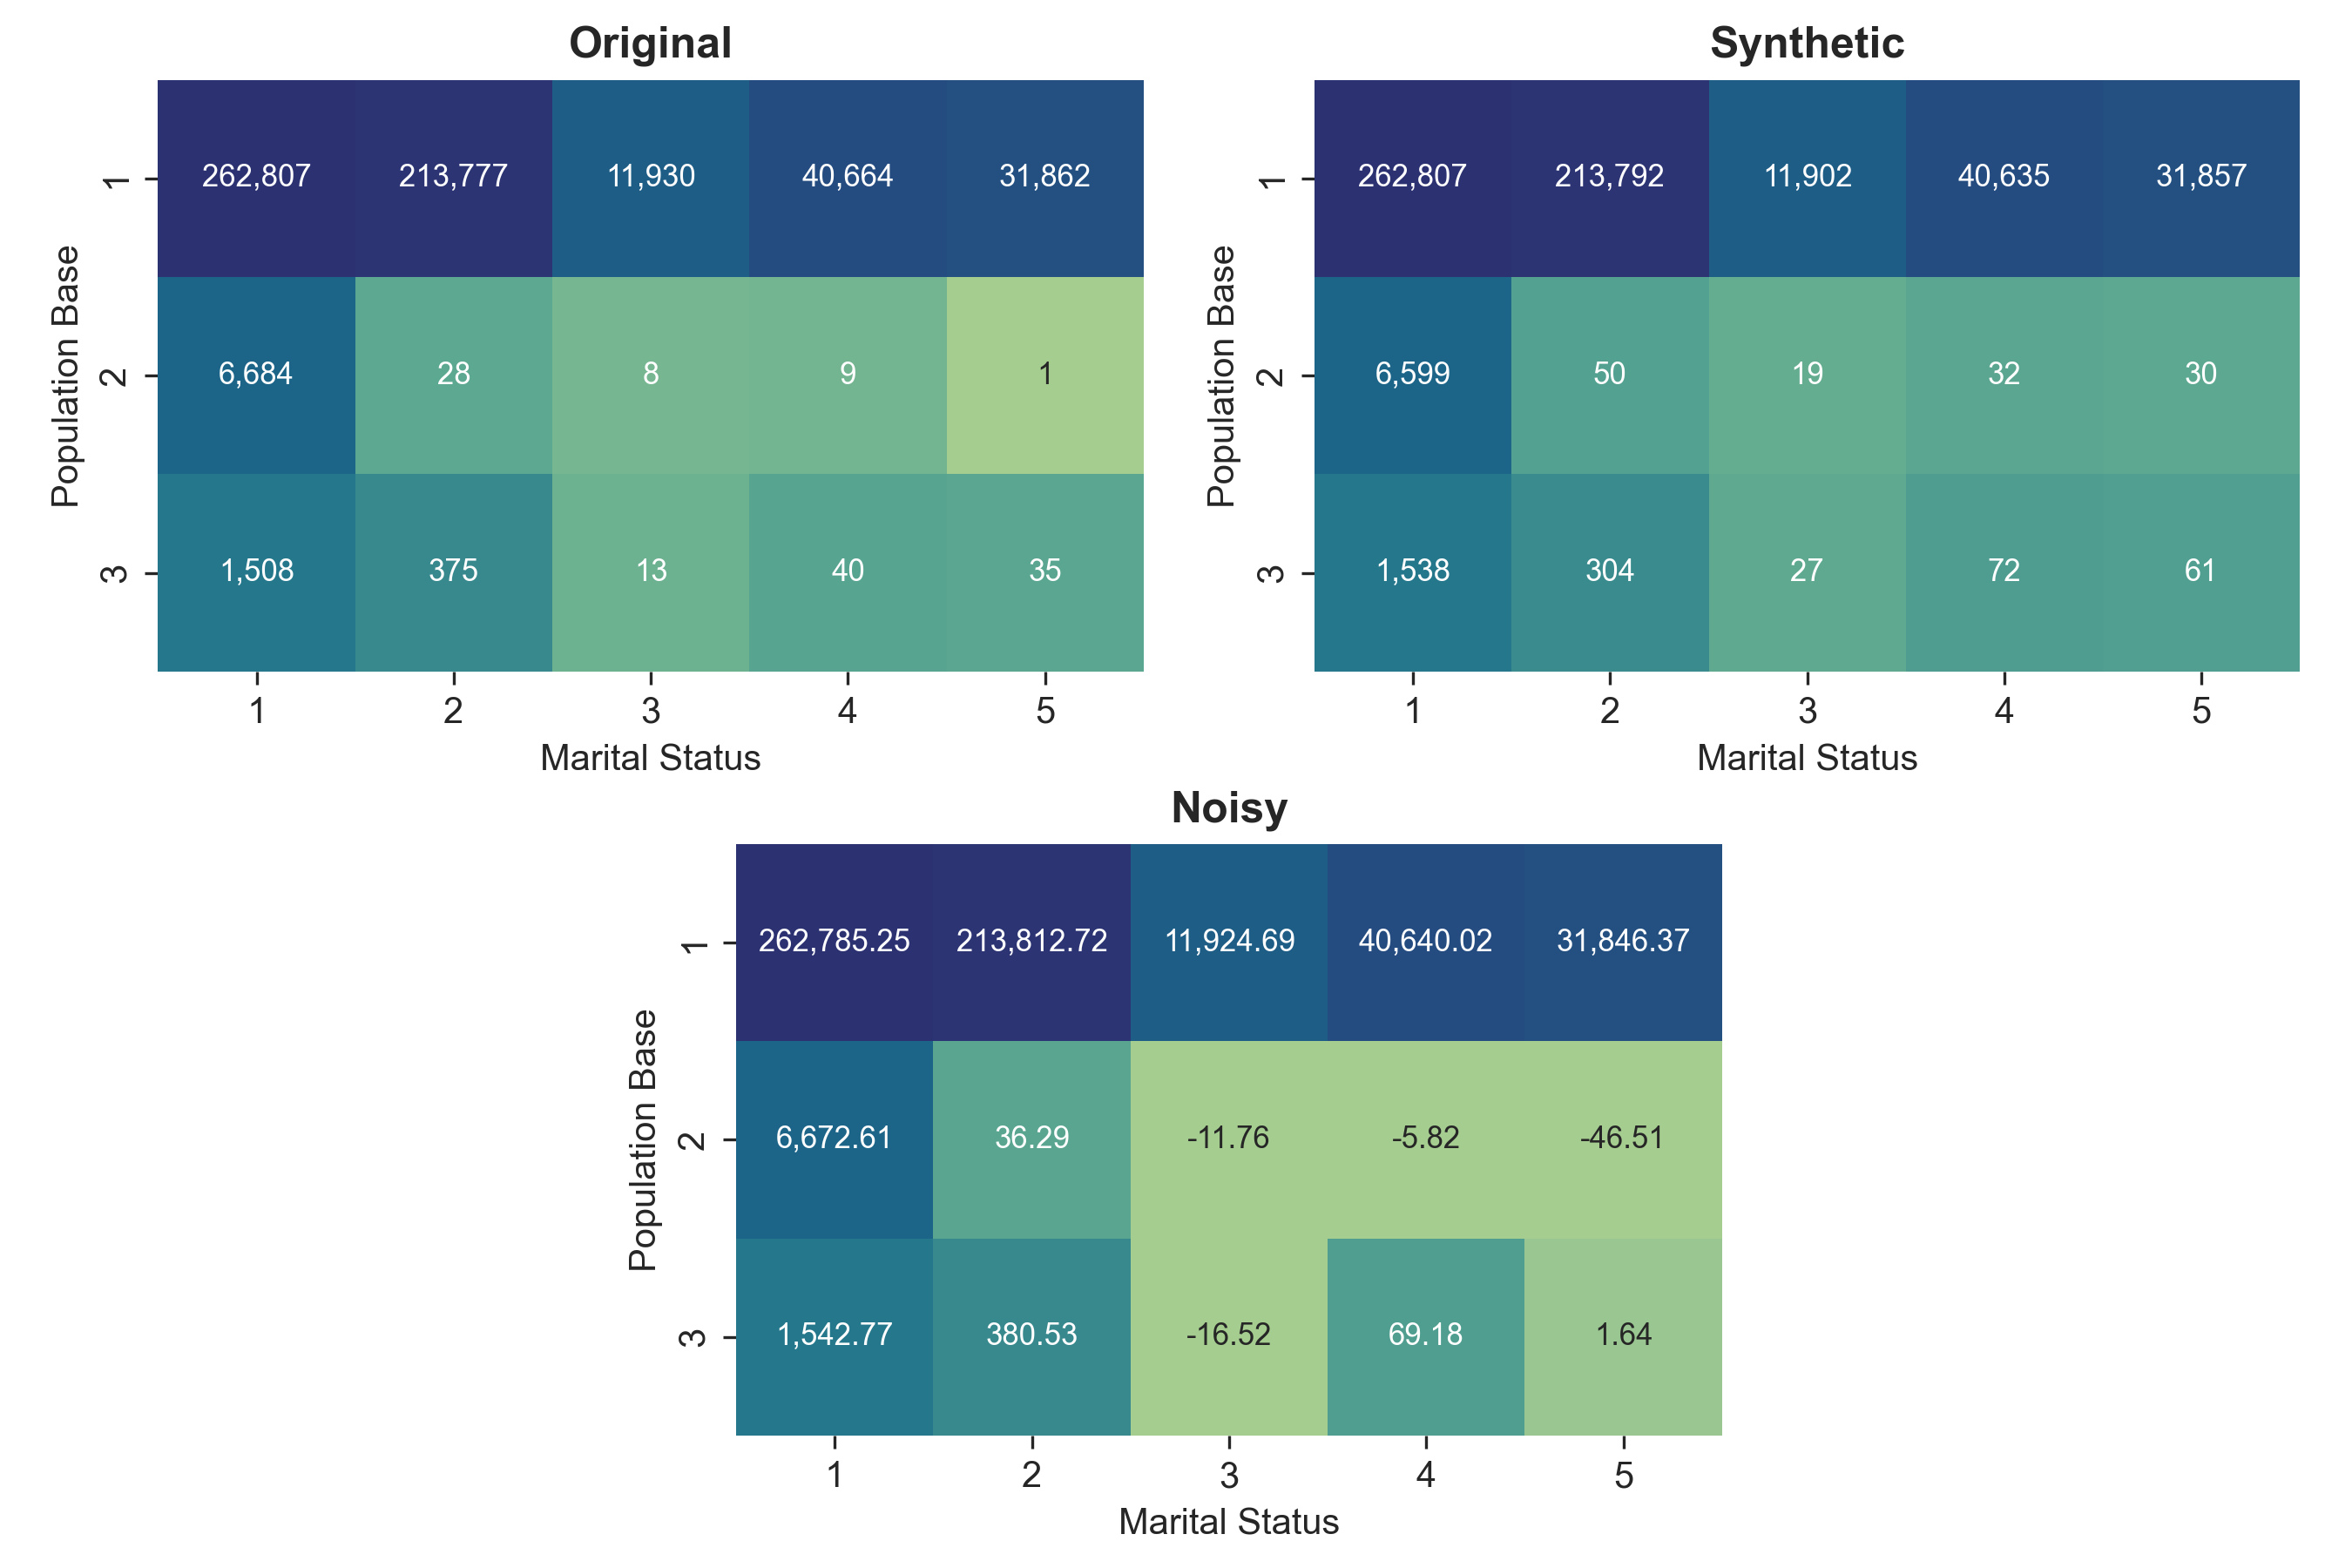

In [21]:
with io.BytesIO() as bio:
    fig = plt.figure(dpi=300, figsize=(9, 6))
    grid = GridSpec(2, 4)

    topleft = fig.add_subplot(grid[0, :2])
    topright = fig.add_subplot(grid[0, 2:])
    bottom = fig.add_subplot(grid[1, 1:3])
    axes = (topleft, bottom, topright)

    for name, table, ax in zip(
        ("Original", "Noisy", "Synthetic"), tables, axes
    ):
        log_table = table.copy()
        log_table[table < 0] = 1
        log_table = np.log(log_table)

        sbn.heatmap(
            log_table,
            annot=table.round(2),
            annot_kws={"fontsize": "small"},
            fmt=",",
            square=True,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap="crest",
            ax=ax,
        )

        ax.set_title(name, fontdict={"weight": "bold"})

    plt.tight_layout()

    fig.canvas.print_png(bio)
    img = binascii.b2a_base64(bio.getvalue())

plt.close()
display(Image(base64.b64decode(img), width="100%"))

In [22]:
latent = ["Population Base", "Sex"]
original_latent = calculate_marginal_table(data, latent, encoder)
synthetic_latent = calculate_marginal_table(synth.df, latent, encoder)
diffs = synthetic_latent - original_latent

mean_abs_diff = diffs.abs().mean().mean().round(2)

---

# Limitations

It is important to note that MST is not a panacaea
for differentially private data synthesis,
and here we lay out two of its limitations.

Among the limitations of MST, though not demonstrated here,
is that it does not scale for columns with large domains;
bear this in mind for your applications.

In [23]:
%%jmd

## Internal inconsistency
[//]: # (-.- .tabset)

Internal inconsistencies are artefacts of synthetic data that should never occur
in the real data. The US Census Bureau's application of DP led to a litany of these
artefacts, including households with no adults and whole districts comprised of elderly
residents.

The Teaching File does not have hierarchical structures like geography or households,
but there are some combinations of values can never occur together.
This type of internal consistency is called a structural zero.
MST does nothing to maintain structural zeroes by default.
The [Python implementation](https://github.com/ryan112358/private-pgm)
(used in this demonstration) includes functionality for maintaining structural zeroes,
but unfortunately there is no documentation available on how to include them.

As such, we can arrive at a reasonable synthetic dataset that includes thousands of
individuals who belong to the student population base and who are not students:

### Original
    
{{ calculate_marginal_table(data, ["Population Base", "Student"], encoder).fillna(0).astype("int").to_html() }}

### Synthetic

{{ calculate_marginal_table(synth.df, ["Population Base", "Student"], encoder).to_html() }}


## Internal inconsistency
<span class='pj-token' style='display: none;'>.tabset</span>

Internal inconsistencies are artefacts of synthetic data that should never occur
in the real data. The US Census Bureau's application of DP led to a litany of these
artefacts, including households with no adults and whole districts comprised of elderly
residents.

The Teaching File does not have hierarchical structures like geography or households,
but there are some combinations of values can never occur together.
This type of internal consistency is called a structural zero.
MST does nothing to maintain structural zeroes by default.
The [Python implementation](https://github.com/ryan112358/private-pgm)
(used in this demonstration) includes functionality for maintaining structural zeroes,
but unfortunately there is no documentation available on how to include them.

As such, we can arrive at a reasonable synthetic dataset that includes thousands of
individuals who belong to the student population base and who are not students:

### Original
    
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Student</th>
      <th>1</th>
      <th>2</th>
    </tr>
    <tr>
      <th>Population Base</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>118715</td>
      <td>442325</td>
    </tr>
    <tr>
      <th>2</th>
      <td>6730</td>
      <td>0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1092</td>
      <td>879</td>
    </tr>
  </tbody>
</table>

### Synthetic

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Student</th>
      <th>1</th>
      <th>2</th>
    </tr>
    <tr>
      <th>Population Base</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>122877</td>
      <td>438116</td>
    </tr>
    <tr>
      <th>2</th>
      <td>3038</td>
      <td>3692</td>
    </tr>
    <tr>
      <th>3</th>
      <td>686</td>
      <td>1316</td>
    </tr>
  </tbody>
</table>

In [24]:
%%jmd

## Unobserved pairs of columns
[//]: # (-.- .tabset)

Close inspection of the marginal tables above reveals another limitation of MST.
That is, MST does not synthesise relationships it does not observe as accurately as those it does.

In truth, MST actually does a pretty good job of doing this because of the `Private-PGM` method.
To demonstrate the efficacy of `Private-PGM` in synthesising latent two-way relationships,
let us look at another pair of columns: `Sex` and `Population Base`.
In the Teaching File, `Sex` is considered binary where `1` indicates _Male_ and `2` indicates _Female_.

Below are the two-way marginals for this latent pair in the original and synthetic data.
The third tab shows the difference from the original in each count.
At a glance from the marginal tables, it may seem things are well-preserved still.

Then, when looking at the differences, the counts are clearly off by some way.
In fact, the mean absolute difference in the marginal table is {{ mean_abs_diff }},
which is considerably larger than for our pair of interest.

So, unobserved relationships are not a wash, but there is a substantial decrease in quality.

### Original

{{ original_latent.style.format("{:,d}").to_html() }}


### Synthetic

{{ synthetic_latent.style.format("{:,d}").to_html() }}


### Difference

{{ diffs.style.format("{:,d}").to_html() }}


## Unobserved pairs of columns
<span class='pj-token' style='display: none;'>.tabset</span>

Close inspection of the marginal tables above reveals another limitation of MST.
That is, MST does not synthesise relationships it does not observe as accurately as those it does.

In truth, MST actually does a pretty good job of doing this because of the `Private-PGM` method.
To demonstrate the efficacy of `Private-PGM` in synthesising latent two-way relationships,
let us look at another pair of columns: `Sex` and `Population Base`.
In the Teaching File, `Sex` is considered binary where `1` indicates _Male_ and `2` indicates _Female_.

Below are the two-way marginals for this latent pair in the original and synthetic data.
The third tab shows the difference from the original in each count.
At a glance from the marginal tables, it may seem things are well-preserved still.

Then, when looking at the differences, the counts are clearly off by some way.
In fact, the mean absolute difference in the marginal table is 117.0,
which is considerably larger than for our pair of interest.

So, unobserved relationships are not a wash, but there is a substantial decrease in quality.

### Original

<style type="text/css">
</style>
<table id="T_bd796">
  <thead>
    <tr>
      <th class="index_name level0" >Sex</th>
      <th id="T_bd796_level0_col0" class="col_heading level0 col0" >1</th>
      <th id="T_bd796_level0_col1" class="col_heading level0 col1" >2</th>
    </tr>
    <tr>
      <th class="index_name level0" >Population Base</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_bd796_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_bd796_row0_col0" class="data row0 col0" >276,174</td>
      <td id="T_bd796_row0_col1" class="data row0 col1" >284,866</td>
    </tr>
    <tr>
      <th id="T_bd796_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_bd796_row1_col0" class="data row1 col0" >3,387</td>
      <td id="T_bd796_row1_col1" class="data row1 col1" >3,343</td>
    </tr>
    <tr>
      <th id="T_bd796_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_bd796_row2_col0" class="data row2 col0" >1,008</td>
      <td id="T_bd796_row2_col1" class="data row2 col1" >963</td>
    </tr>
  </tbody>
</table>



### Synthetic

<style type="text/css">
</style>
<table id="T_b3f53">
  <thead>
    <tr>
      <th class="index_name level0" >Sex</th>
      <th id="T_b3f53_level0_col0" class="col_heading level0 col0" >1</th>
      <th id="T_b3f53_level0_col1" class="col_heading level0 col1" >2</th>
    </tr>
    <tr>
      <th class="index_name level0" >Population Base</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_b3f53_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_b3f53_row0_col0" class="data row0 col0" >276,341</td>
      <td id="T_b3f53_row0_col1" class="data row0 col1" >284,652</td>
    </tr>
    <tr>
      <th id="T_b3f53_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_b3f53_row1_col0" class="data row1 col0" >3,269</td>
      <td id="T_b3f53_row1_col1" class="data row1 col1" >3,461</td>
    </tr>
    <tr>
      <th id="T_b3f53_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_b3f53_row2_col0" class="data row2 col0" >981</td>
      <td id="T_b3f53_row2_col1" class="data row2 col1" >1,021</td>
    </tr>
  </tbody>
</table>



### Difference

<style type="text/css">
</style>
<table id="T_461bd">
  <thead>
    <tr>
      <th class="index_name level0" >Sex</th>
      <th id="T_461bd_level0_col0" class="col_heading level0 col0" >1</th>
      <th id="T_461bd_level0_col1" class="col_heading level0 col1" >2</th>
    </tr>
    <tr>
      <th class="index_name level0" >Population Base</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_461bd_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_461bd_row0_col0" class="data row0 col0" >167</td>
      <td id="T_461bd_row0_col1" class="data row0 col1" >-214</td>
    </tr>
    <tr>
      <th id="T_461bd_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_461bd_row1_col0" class="data row1 col0" >-118</td>
      <td id="T_461bd_row1_col1" class="data row1 col1" >118</td>
    </tr>
    <tr>
      <th id="T_461bd_level0_row2" class="row_heading level0 row2" >3</th>
      <td id="T_461bd_row2_col0" class="data row2 col0" >-27</td>
      <td id="T_461bd_row2_col1" class="data row2 col1" >58</td>
    </tr>
  </tbody>
</table>